In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import bayesian_pdes as bpdes
import sympy as sp
import numpy as np
from scipy import stats

In [3]:
x,y = sp.symbols('x y')
sigma = 0.1
k = sp.exp(-(x-y)**2 / (2*sigma**2))

A = lambda k: k.diff(x,x)
Abar = lambda k: k.diff(y,y)
B = lambda k: k
Bbar = B

ops = [A,B]
ops_bar = [Abar, Bbar]

op_cache = bpdes.generate_op_cache(ops, ops_bar, k, [[x], [y]])

In [4]:
collocate_points = np.linspace(0,1,21)[1:-1, None]
bdy_points = np.array([[0.], [1.]])
bdy_vals = np.array([[0.], [0.]])
data_points = np.linspace(0,1,11)[1:-1, None]
#data_vals = -np.sin(2*np.pi*data_points) / (4*np.pi**2)
data_vals = 0.5*(data_points**2 - data_points)

# Parametric RHS

Here we are trying to solve:

$$
\nabla ^2 u = \lambda \\
u = 0\\
D = [0,1] \\
$$

True data is $\lambda = 1$. This has solution $\frac{\lambda}{2} (x^2 + x)$

In [4]:
def get_posterior(theta):
    rhs = theta * np.ones_like(collocate_points)
    obs = [(collocate_points, rhs), (bdy_points, bdy_vals)]
    
    posterior = bpdes.collocate(ops, ops_bar, None, None, obs, op_cache)
    return posterior

def log_likelihood(theta):
    posterior = get_posterior(theta)
    mu, cov = posterior(data_points)
    log_lik = stats.multivariate_normal.logpdf(mu.ravel(), data_vals.ravel(), cov + likelihood_sigma**2*np.eye(cov.shape[0]))
    return log_lik

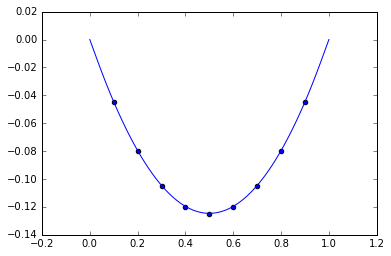

In [5]:
post = get_posterior(1)
test_points = np.linspace(0,1,101)[:,None]
mu, cov = post(test_points)
plt.plot(test_points, mu)
plt.scatter(data_points, data_vals)

In [6]:
likelihood_sigma = 0.001

log_likelihood(1)

48.575394173377347

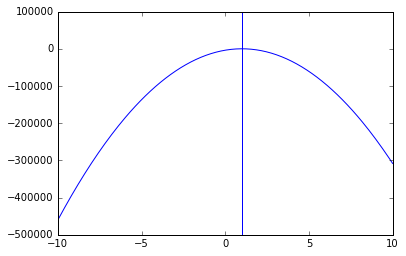

In [7]:
test_points = np.linspace(-10,10,200)
ll = np.array([log_likelihood(p) for p in test_points])
plt.plot(test_points, ll)
plt.axvline(1)

So that seems to make sense as a likelihood. Now let's try an MCMC.

In [8]:
def proposal(theta):
    return theta + np.random.normal(0, proposal_sigma)

In [9]:
N = 5000
cur_theta = 0.
cur_log_likelihood = log_likelihood(cur_theta)
samples = np.empty((N, 1))
accepts = np.empty(N, dtype=np.bool)
proposal_sigma = 0.01
update_freq = int(N/10)
for i in xrange(N):
    new_theta = proposal(cur_theta)
    new_log_likelihood = log_likelihood(new_theta)
    alpha = min(1, np.exp(new_log_likelihood - cur_log_likelihood))
    accept = np.random.uniform() < alpha
    if accept:
        cur_theta = new_theta
        cur_log_likelihood = new_log_likelihood
    samples[i, :] = cur_theta
    accepts[i] = accept
    if (i % update_freq) == 0 and i>0:
        delta_accept = accepts[(i-update_freq):i].mean()
        tot_accept = accepts[:i].mean()
        print 'Iter {}: Delta Accept {:.2f} Tot Accept {:.2f}'.format(i, delta_accept, tot_accept)

Iter 500: Delta Accept 0.63 Tot Accept 0.63
Iter 1000: Delta Accept 0.71 Tot Accept 0.67
Iter 1500: Delta Accept 0.73 Tot Accept 0.69
Iter 2000: Delta Accept 0.77 Tot Accept 0.71
Iter 2500: Delta Accept 0.72 Tot Accept 0.71
Iter 3000: Delta Accept 0.71 Tot Accept 0.71
Iter 3500: Delta Accept 0.74 Tot Accept 0.71
Iter 4000: Delta Accept 0.69 Tot Accept 0.71
Iter 4500: Delta Accept 0.73 Tot Accept 0.71


In [10]:
burn = 1000
thin = 1
thinned_burned = samples[burn:-1:thin, :]

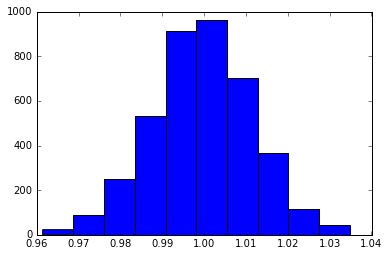

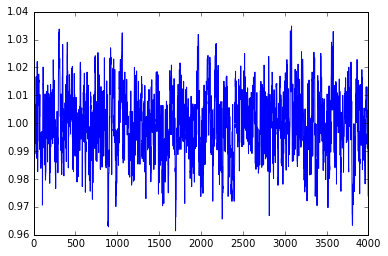

In [11]:
plt.hist(thinned_burned)
plt.figure()
plt.plot(thinned_burned)

# Nonparametric RHS

Now let's look at:

$$
\nabla^2 u = \kappa(x)
u(0) = u(1) = 0
$$

True data is $\kappa(x) = \sin(2\pi x)$. This has true solution $u = -\frac{\sin(2\pi x)}{4\pi^2}$

In [6]:
import mcmc
data_vals = -np.sin(2*np.pi*data_points) / (4*np.pi**2)

In [7]:
discretisation_points = collocate_points
K_mat = op_cache[()](discretisation_points, discretisation_points)

In [11]:
def get_posterior(theta):
    obs = [(collocate_points, theta), (bdy_points, bdy_vals)]
    
    posterior = bpdes.collocate(ops, ops_bar, None, None, obs, op_cache)
    return posterior

def phi(theta):
    posterior = get_posterior(theta)
    mu, cov = posterior(data_points)
    log_lik = stats.multivariate_normal.logpdf(mu.ravel(), data_vals.ravel(), cov + likelihood_sigma**2*np.eye(cov.shape[0]))
    return -log_lik

In [20]:
proposal_pcn = mcmc.pcn.proposal(0.1, K_mat)
theta_0 = np.zeros_like(discretisation_points)
samples = mcmc.pcn.pCN(50000, proposal_pcn, phi, theta_0)

Iter 500: Delta Accept 0.16 Tot Accept 0.16 T/Iter 2.7893
Iter 1000: Delta Accept 0.13 Tot Accept 0.15 T/Iter 3.5208
Iter 1500: Delta Accept 0.14 Tot Accept 0.14 T/Iter 3.3511
Iter 2000: Delta Accept 0.10 Tot Accept 0.13 T/Iter 2.6777
Iter 2500: Delta Accept 0.14 Tot Accept 0.14 T/Iter 3.5060
Iter 3000: Delta Accept 0.12 Tot Accept 0.13 T/Iter 2.8374
Iter 3500: Delta Accept 0.11 Tot Accept 0.13 T/Iter 2.5665
Iter 4000: Delta Accept 0.12 Tot Accept 0.13 T/Iter 2.6516
Iter 4500: Delta Accept 0.14 Tot Accept 0.13 T/Iter 2.4484
Iter 5000: Delta Accept 0.11 Tot Accept 0.13 T/Iter 2.6250
Iter 5500: Delta Accept 0.12 Tot Accept 0.13 T/Iter 2.7834
Iter 6000: Delta Accept 0.15 Tot Accept 0.13 T/Iter 2.9427
Iter 6500: Delta Accept 0.14 Tot Accept 0.13 T/Iter 2.5153
Iter 7000: Delta Accept 0.14 Tot Accept 0.13 T/Iter 3.2758
Iter 7500: Delta Accept 0.12 Tot Accept 0.13 T/Iter 2.4681
Iter 8000: Delta Accept 0.14 Tot Accept 0.13 T/Iter 2.6955
Iter 8500: Delta Accept 0.13 Tot Accept 0.13 T/Iter 2.675

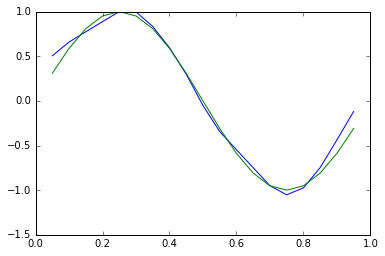

In [21]:
plt.plot(discretisation_points, np.mean(samples[5000:], axis=0))
plt.plot(discretisation_points, np.sin(2*np.pi*discretisation_points))

# Parametric Diffusivity

In [22]:
data = np.loadtxt('data_simple')
data_points = data[:,0][:,None]
data_vals = data[:,1][:,None]

In [23]:
theta_1 = sp.symbols('theta_1')
A = lambda k: (sp.exp(theta_1*sp.sin(2*sp.pi*x)) * k.diff(x)).diff(x)
Abar = lambda k: (sp.exp(theta_1*sp.sin(2*sp.pi*y))*k.diff(y)).diff(y)
B = lambda k: k
Bbar = B

ops = [A,B]
ops_bar = [Abar, Bbar]

op_cache = bpdes.generate_op_cache(ops, ops_bar, k, [[x], [y], [theta_1]])

In [24]:
bdy_vals = np.array([[1.], [1.]])

In [101]:
def get_posterior(thetas):
    rhs = np.sin(2*np.pi*collocate_points)
    obs = [(collocate_points, rhs), (bdy_points, bdy_vals)]
    posterior = bpdes.collocate(ops, ops_bar, None, None, obs, op_cache, fun_args=[thetas])
    return posterior

def log_likelihood(theta):
    posterior = get_posterior(np.array([theta]))
    mu, cov = posterior(data_points)
    log_lik = stats.multivariate_normal.logpdf(mu.ravel(), data_vals.ravel(), cov + likelihood_sigma**2*np.eye(cov.shape[0]))
    return log_lik

In [103]:
log_likelihood(1.0)

-283.63302614821077

In [106]:
t = np.linspace(0,2,101)
liks = np.array([log_likelihood(tval) for tval in t])

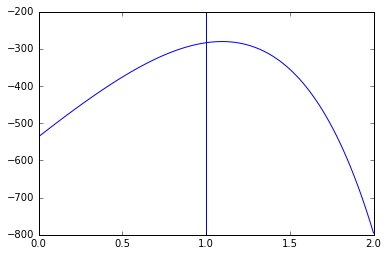

In [107]:
plt.plot(t, liks)
plt.axvline(1.)

In [117]:
# now MCMC
N = 5000
cur_theta = 0.
cur_log_likelihood = log_likelihood(cur_theta)
samples = np.empty((N, 1))
accepts = np.empty(N, dtype=np.bool)
proposal_sigma = 0.1
update_freq = int(N/10)
for i in xrange(N):
    new_theta = proposal(cur_theta)
    new_log_likelihood = log_likelihood(new_theta)
    alpha = min(1, np.exp(new_log_likelihood - cur_log_likelihood))
    accept = np.random.uniform() < alpha
    if accept:
        cur_theta = new_theta
        cur_log_likelihood = new_log_likelihood
    samples[i, :] = cur_theta
    accepts[i] = accept
    if (i % update_freq) == 0 and i>0:
        delta_accept = accepts[(i-update_freq):i].mean()
        tot_accept = accepts[:i].mean()
        print 'Iter {}: Delta Accept {:.2f} Tot Accept {:.2f}'.format(i, delta_accept, tot_accept)

Iter 500: Delta Accept 0.41 Tot Accept 0.41
Iter 1000: Delta Accept 0.43 Tot Accept 0.42
Iter 1500: Delta Accept 0.39 Tot Accept 0.41
Iter 2000: Delta Accept 0.42 Tot Accept 0.41
Iter 2500: Delta Accept 0.39 Tot Accept 0.41
Iter 3000: Delta Accept 0.43 Tot Accept 0.41
Iter 3500: Delta Accept 0.38 Tot Accept 0.41
Iter 4000: Delta Accept 0.43 Tot Accept 0.41
Iter 4500: Delta Accept 0.39 Tot Accept 0.41


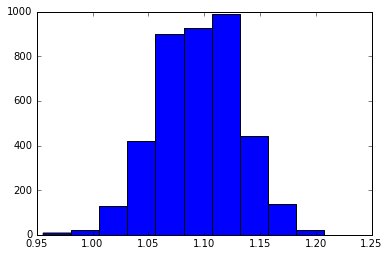

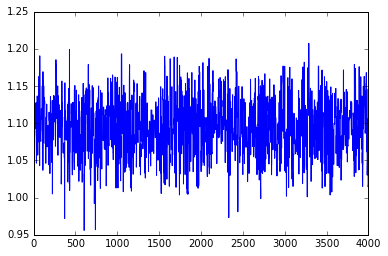

In [118]:
burn = 1000
thinned_burned = samples[burn:]
plt.hist(thinned_burned)
plt.figure()
plt.plot(thinned_burned)

# Nonparametric Diffusivity

I need my MCMC to run over both the function and its gradient now.

In [26]:
# First set up the covariance
prop_kernel = k
prop_A = lambda k: k
prop_B = lambda k: k.diff(x)
prop_Abar = prop_A
prop_Bbar = lambda k: k.diff(y)

prop_ops = [prop_A, prop_B]
prop_ops_bar = [prop_Abar, prop_Bbar]
prop_oc = bpdes.generate_op_cache(prop_ops, prop_ops_bar, prop_kernel, [[x], [y]])

prop_K = bpdes.collocation.calc_LLbar(prop_ops, prop_ops_bar, ((discretisation_points, None), (discretisation_points, None)), prop_oc)

In [27]:
class NamedLambda(object):
    def __init__(self, func, desc):
        self.__func__ = func
        self.__desc__ = desc
    def __call__(self, *args):
        return self.__func__(*args)
    def __str__(self):
        return '<NamedLambda: {}>'.format(self.__desc__)
    def __repr__(self):
        return '<NamedLambda: {}>'.format(self.__desc__)
A_1 = NamedLambda(lambda k: k.diff(x), 'A_1')
A_2 = NamedLambda(lambda k: k.diff(x, x), 'A_2')
A_1_bar = NamedLambda(lambda k: k.diff(y), 'A_1_bar')
A_2_bar = NamedLambda(lambda k: k.diff(y, y), 'A_2_bar')

tmp_oc = bpdes.generate_op_cache([A_1,A_2,B], [A_1_bar, A_2_bar,Bbar], k, [[x], [y]])

In [28]:
import joblib
# I really don't like this. It is dangerous - I'd much rather have it in memory
class CachedOpCache(object):
    def __init__(self, op_cache, cache_verbosity=0, clear_cache=True):
        self.__op_cache__ = op_cache
        self.__fun_cache__ = {}
        self.__cacher__ = joblib.Memory(cachedir='/tmp/npcache', mmap_mode='r', verbose=cache_verbosity)
        if clear_cache:
            self.__cacher__.clear()
    
    def __getitem__(self, item):
        if item in self.__fun_cache__:
            return self.__fun_cache__[item]
        
        underlying = self.__op_cache__[item]
        cached_version = self.__cacher__.cache(underlying)
        self.__fun_cache__[item] = cached_version
        return cached_version

A_trans = 'A'
A_bar_trans = 'Abar'

class TransformedOpCache(object):
    def __init__(self, op_cache, kappa, grad_kappa):
        self.__op_cache__ = op_cache
        self.__kappa__ = kappa
        self.__grad_kappa__ = grad_kappa
    
    def __getitem__(self, item):
        return do_transform(item, self.__op_cache__, self.__kappa__, self.__grad_kappa__)

def do_transform(item, op_cache, kappa, grad_kappa):
    kappa = kappa.reshape((len(kappa), 1))
    grad_kappa = grad_kappa.reshape((len(grad_kappa),1))
    all_things = [()]
    
    # first explode out the objects required
    for i in item:
        if i == A_trans:
            all_things = sum([[a + (A_1,), a + (A_2,)] for a in all_things], [])
        elif i == A_bar_trans:
            all_things = sum([[a + (A_1_bar,), a + (A_2_bar,)] for a in all_things], [])
        else:
            all_things = [a + (i,) for a in all_things]

    def __calc_result(x,y):
        result = 0
        for item in all_things:
            function = op_cache[item]
            new_mat = function(x,y)
            if A_1 in item:
                #print 'A_1'
                new_mat = np.repeat(grad_kappa,y.shape[0],1) * new_mat
            elif A_2 in item:
                #print 'A_2'
                new_mat = np.repeat(kappa,y.shape[0],1) * new_mat
            if A_1_bar in item:
                #print 'A_1_bar'
                new_mat = np.repeat(grad_kappa.T,x.shape[0],0) * new_mat
            elif A_2_bar in item:
                #print 'A_2_bar'
                new_mat = np.repeat(kappa.T,x.shape[0],0) * new_mat
            result += new_mat
        return result
    return __calc_result

In [29]:
#tmp_oc_1 = CachedOpCache(tmp_oc)
oc = TransformedOpCache(tmp_oc, np.zeros_like(discretisation_points), np.ones_like(discretisation_points))

In [43]:
likelihood_sigma = 0.01
def get_posterior(kappa, grad_kappa):
    obs = [(collocate_points, np.zeros_like(collocate_points)), (bdy_points, bdy_vals)]
    oc = TransformedOpCache(tmp_oc, kappa, grad_kappa)
    posterior = bpdes.collocate([A_trans, B], [A_bar_trans, Bbar], None, None, obs, oc)
    return posterior

def phi(theta):
    kappa = theta[:len(discretisation_points), :]
    grad_kappa = theta[len(discretisation_points):, :]
    posterior = get_posterior(kappa, grad_kappa)
    mu, cov = posterior(data_points)
    log_lik = stats.multivariate_normal.logpdf(mu.ravel(), data_vals.ravel(), cov + likelihood_sigma**2*np.eye(cov.shape[0]))
    return -log_lik

In [70]:
sp.sin(2*sp.pi*x).diff(x)

2*pi*cos(2*pi*x)

In [71]:
kappa_0 = np.concatenate([np.sin(2*np.pi*discretisation_points), 2*np.pi*np.cos(2*np.pi*discretisation_points)])
phi(kappa_0)

-4.4689628916068536

In [83]:
beta = 0.075
proposal = mcmc.pcn.proposal(beta, prop_K)

In [102]:
#kappa_0 = np.concatenate([np.ones_like(discretisation_points), np.zeros_like(discretisation_points)])
samples = mcmc.pcn.pCN(int(1e6), proposal, phi, kappa_0)

Iter 10000: Delta Accept 0.26 Tot Accept 0.26 T/Iter 0.0139
Iter 20000: Delta Accept 0.31 Tot Accept 0.29 T/Iter 0.0137
Iter 30000: Delta Accept 0.25 Tot Accept 0.27 T/Iter 0.0130
Iter 40000: Delta Accept 0.33 Tot Accept 0.29 T/Iter 0.0129
Iter 50000: Delta Accept 0.34 Tot Accept 0.30 T/Iter 0.0130
Iter 60000: Delta Accept 0.28 Tot Accept 0.30 T/Iter 0.0129
Iter 70000: Delta Accept 0.35 Tot Accept 0.31 T/Iter 0.0132
Iter 80000: Delta Accept 0.39 Tot Accept 0.32 T/Iter 0.0130
Iter 90000: Delta Accept 0.37 Tot Accept 0.32 T/Iter 0.0130
Iter 100000: Delta Accept 0.59 Tot Accept 0.35 T/Iter 0.0130
Iter 110000: Delta Accept 0.55 Tot Accept 0.37 T/Iter 0.0130
Iter 120000: Delta Accept 0.58 Tot Accept 0.39 T/Iter 0.0130
Iter 130000: Delta Accept 0.58 Tot Accept 0.40 T/Iter 0.0130
Iter 140000: Delta Accept 0.55 Tot Accept 0.41 T/Iter 0.0131
Iter 150000: Delta Accept 0.56 Tot Accept 0.42 T/Iter 0.0130
Iter 160000: Delta Accept 0.50 Tot Accept 0.43 T/Iter 0.0130
Iter 170000: Delta Accept 0.48 To

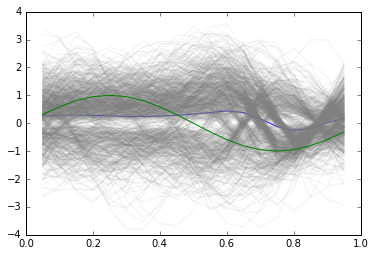

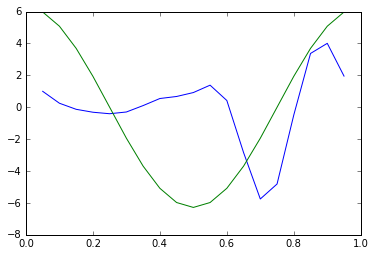

In [106]:
burn = int(1e5)
thinned_burned = samples[burn:,:]
kappa_tb = thinned_burned[:, :len(discretisation_points)]
grad_kappa_tb = thinned_burned[:, len(discretisation_points):]

plt.plot(discretisation_points, kappa_tb.mean(axis=0))
plt.plot(discretisation_points, kappa_tb[::1000].T, c='gray', alpha=0.1)
plt.plot(discretisation_points, np.sin(2*np.pi*discretisation_points))
plt.figure()
plt.plot(discretisation_points, grad_kappa_tb.mean(axis=0))
plt.plot(discretisation_points, np.cos(2*np.pi*discretisation_points)*2*np.pi)

In [98]:
print phi(thinned_burned.mean(axis=0)[:,None])
print phi(kappa_0)

-17.1482469275
-4.46896289161
